In [1]:
MDtrajs_dir="./MDtrajs/"
Featurization_dir="./Featurization/"
GMRQ_dir="./GMRQ/"
MicroMSM_dir='./MicroMSM/'
MacroMSM_dir='./MacroMSM/'

topfile = MDtrajs_dir + "ala2.pdb"

### Cross Validation of TICA parameters based on GMRQ Score

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from msmbuilder.decomposition import tICA
from msmbuilder.cluster import KMeans, KCenters, MiniBatchKMeans
from msmbuilder.msm import MarkovStateModel
import multiprocessing
from joblib import Parallel, delayed

In [ ]:
for para in ['lagtime', 'n_tics', 'n_clusters']:
    para_dir = GMRQ_dir + para + '/'
    if not os.path.exists(para_dir):
        os.mkdir(para_dir)

ftrajs = np.load(Featurization_dir + 'ftrajs.npy', allow_pickle=True)
        
def TICA_CV(lt=2, n_tics=3, n_clusters=800, trajs=ftrajs, runs=10, n_fold=5, para='lagtime'):
    
    output_files_dir = GMRQ_dir + para + '/'
    
    results = []
    for run in range(runs):
        cv = KFold(n_splits=n_fold, shuffle=True)
        for train_index, test_index in cv.split(trajs):
            
            train_data = [trajs[i] for i in train_index]
            test_data = [trajs[i] for i in test_index]
            
            tica = tICA(n_components=n_tics, lag_time=lt, kinetic_mapping=True)
            tica.fit(train_data)
            ttraj_train = tica.transform(train_data)
            ttraj_test = tica.transform(test_data)
            
            cluster = KCenters(n_clusters=n_clusters)
            cluster.fit(ttraj_train)
            ctraj_train = cluster.predict(ttraj_train)
            ctraj_test = cluster.predict(ttraj_test)
            
            msm = MarkovStateModel(n_timescales=4, lag_time=100, reversible_type='transpose', 
                                   verbose=False, ergodic_cutoff='off')
            msm.fit(ctraj_train)
            train_score = msm.score(ctraj_train)
            test_score = msm.score(ctraj_test)
            
            results.append({
                'type': 'train', 'score': train_score, 
                'lagtime': lt, 'n_tics': n_tics, 'n_clusters': n_clusters})
            results.append({
                'type': 'test', 'score': test_score, 
                'lagtime': lt, 'n_tics': n_tics, 'n_clusters': n_clusters})
            
        print('Run {} for {}lt, {}tics, {}clusters is complete'.format(run,lt,n_tics,n_clusters))
    frame = pd.DataFrame(results)
    frame.to_pickle(output_files_dir + "{}lt_{}tics_{}clusters_gmrq.pickl".format(lt,n_tics,n_clusters))

In [ ]:
# Cross-validation for lag time
lt_list = [1,2,4,8,16]
Parallel(n_jobs=5)(delayed(TICA_CV)\
                   (lt=i, n_tics=3, n_clusters=800, para='lagtime') for i in lt_list)

In [ ]:
# Cross-validation for number of tICs
ntics_list = [2,3,4,5]
Parallel(n_jobs=4)(delayed(TICA_CV)\
                   (lt=2, n_tics=i, n_clusters=800, para='n_tics') for i in ntics_list)

In [ ]:
# Cross-validation for number of clusters
nc_list = [400, 600, 800, 1000, 1200]
Parallel(n_jobs=5)(delayed(TICA_CV)\
                   (lt=2, n_tics=3, n_clusters=i, para=' n_clusters') for i in nc_list)

### Plot the cross validation results

In [3]:
import glob
import pickle
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

def load_pickles(file_dir):
    pickle_files = glob.glob(file_dir)
    data_list = []
    for file in pickle_files:
        with open(file, "rb") as f:
            data = pickle.load(f)
            data_list.append(data)
    return data_list

delta_t = 0.1

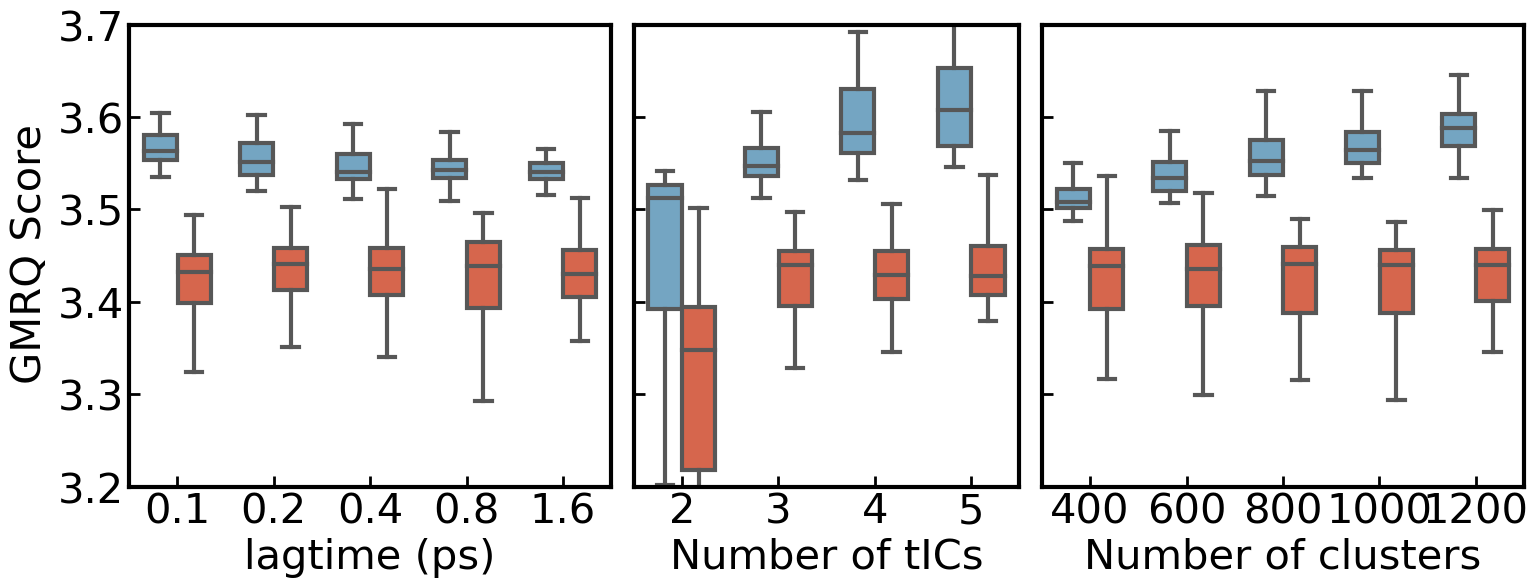

In [4]:
plt.rcParams['font.size'] = 30
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True,
                         gridspec_kw={'width_ratios': [5, 4, 5]})

pal = {'train': '#67a9cf', 'test': '#ed5736'}
para = ['lagtime', 'n_tics', 'n_clusters']

for i in range(len(para)):
    file_dir = GMRQ_dir + para[i] + '/'
    data = load_pickles(file_dir + '*.pickl')
    df = pd.concat(data, axis=0)
    df['lagtime'] = df['lagtime'] * delta_t
    sns.boxplot(data=df, x=para[i], y='score', hue='type', 
                orient="v", notch=False, 
                palette=pal, linewidth=3, width=0.7, 
                sym=".", showfliers=False, ax=axes[i])
    axes[i].set_ylabel("")   
    axes[i].set_ylim(3.2, 3.7)
    axes[i].legend([], frameon=False)
    axes[i].tick_params(axis='both', direction='in', width=2, length=8)
    for spine in axes[i].spines.values():
        spine.set_linewidth(3)
        
axes[0].set_xlabel("lagtime (ps)")
axes[1].set_xlabel("Number of tICs")
axes[2].set_xlabel("Number of clusters")
fig.text(0.07, 0.5, "GMRQ Score", ha='center', va='center', rotation=90)

plt.subplots_adjust(wspace=0.05)
plt.savefig('./png/gmrq_tica.png', dpi=1000, bbox_inches='tight')

plt.show()